In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, precision_score, recall_score

# Import Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [ ]:
"""
Project Overview

Mục tiêu của notebook này:

- Xây dựng pipeline tiền xử lý dữ liệu từ `data/processed_data.csv`. 
- Triển khai các mô hình phân loại để dự đoán đơn hàng có sinh lời (HighValueCustomer).
- Thực hiện phân tích bổ sung: Time-series (dự báo doanh thu), Market Basket (gợi ý sản phẩm) và Customer Churn (dự đoán rời bỏ).

Hướng dẫn ngắn:
- Chạy theo thứ tự: (1) Load & preprocess -> (2) Huấn luyện & đánh giá -> (3) Phân tích bổ sung.
"""


## 1. Chuẩn bị dữ liệu

### Load dữ liệu & Ghi chú tiền xử lý

Cell này thực hiện:

- Tự động dò `sep` (`,`, `;`, `\t`, `|`) và encoding để đọc file `data/processed_data.csv` (hoặc fallback `processed_data.csv`).
- Chuẩn hoá số thập phân từ `,` -> `.` và chuyển các cột số sang dtype phù hợp.
- Tạo target `HighValueCustomer` dựa trên `TOTALBASKET` (median split).

Lưu ý: nếu file dùng `;` làm delimiter thì code đã xử lý conversion cho cột `TOTALBASKET`, `UNITPRICE`, `TOTALPRICE`, `AMOUNT`.


In [ ]:
# Load processed data with encoding handling and delimiter detection
from csv import Sniffer

def detect_sep(path):
    try:
        with open(path, 'r', encoding='utf-8', errors='ignore') as f:
            sample = f.read(2048)
        dialect = Sniffer().sniff(sample, delimiters=[',',';','\t','|'])
        return dialect.delimiter
    except Exception:
        return ','


def robust_read_processed(path1='data/processed_data.csv', path2='processed_data.csv'):
    for path in [path1, path2]:
        try:
            sep = detect_sep(path)
            df = pd.read_csv(path, sep=sep, encoding='utf-8', on_bad_lines='skip', engine='python')
            print(f"Loaded {path} with sep='{sep}'")
            return df, sep
        except FileNotFoundError:
            continue
        except Exception as e:
            try:
                df = pd.read_csv(path, sep=';', encoding='latin1', on_bad_lines='skip', engine='python')
                print(f"Loaded {path} with latin1 and sep=';'")
                return df, ';'
            except Exception:
                print(f"Failed to load {path}: {e}")
    raise FileNotFoundError("Processed data file not found or could not be read.")

# Read the file
df, detected_sep = robust_read_processed()

# If separator is semicolon or TOTALBASKET is object, attempt to normalize numeric columns with comma decimals
if detected_sep == ';' or ("TOTALBASKET" in df.columns and df['TOTALBASKET'].dtype == object):
    for col in ['TOTALBASKET', 'UNITPRICE', 'TOTALPRICE', 'AMOUNT']:
        if col in df.columns:
            df[col] = df[col].astype(str).str.replace(',', '.').str.replace('\\s','', regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce')

# DEBUG: In columns để kiểm tra
print("Các cột trong file:", df.columns.tolist())

# Chọn các features cơ bản tồn tại trong file
# Fallback: Nếu không tìm thấy cột chính xác, hãy thử tìm cột tương tự hoặc bỏ qua
expected_cols = ['TOTALBASKET', 'Age', 'USERGENDER', 'REGION', 'AMOUNT']
available_cols = [c for c in expected_cols if c in df.columns]

if 'TOTALBASKET' not in df.columns:
    print("LỖI: Không tìm thấy cột TOTALBASKET để làm target!")
    # Stop execution manually if needed, or let it crash later
else:
    df = df.dropna(subset=available_cols)

    # Tạo target class (0/1 High Value)
    threshold = df['TOTALBASKET'].median()
    df['HighValueCustomer'] = (df['TOTALBASKET'] > threshold).astype(int)

    # Chọn features
    # Update feature_cols based on what is available (excluding target features)
    feature_cols = [c for c in available_cols if c != 'TOTALBASKET']
    if 'Month' in df.columns:
        feature_cols.append('Month')
    
    print("Features được chọn:", feature_cols)
    target_col = 'HighValueCustomer'

    X = df[feature_cols].copy()
    y = df[target_col]

    # Encoding - chỉ encode nếu cột tồn tại
    if 'USERGENDER' in X.columns:
        le_gender = LabelEncoder()
        X['USERGENDER'] = le_gender.fit_transform(X['USERGENDER'])

    if 'REGION' in X.columns:
        le_region = LabelEncoder()
        X['REGION'] = le_region.fit_transform(X['REGION'])
    # Split Train/Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scaling (Quan trọng cho KNN, SVM, Logistic Regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")

Loaded cleandata/processed_data.csv with latin1 and sep=';'
Các cột trong file: ['ORDERID', 'ORDERDETAILID', 'AMOUNT', 'UNITPRICE', 'TOTALPRICE', 'ITEMID', 'ITEMCODE', 'BRANCH_ID', 'DATE_', 'USERID', 'NAMESURNAME_x', 'TOTALBASKET', 'USERNAME_', 'NAMESURNAME_y', 'STATUS_', 'USERGENDER', 'USERBIRTHDATE', 'REGION', 'CITY', 'TOWN', 'DISTRICT', 'ADDRESSTEXT', 'Year', 'Month', 'Age']
Features được chọn: ['Age', 'USERGENDER', 'REGION', 'AMOUNT', 'Month']
Training set size: 40000 samples
Test set size: 10000 samples


## 2. Huấn luyện hàng loạt (Batch Training)

### Huấn luyện & Đánh giá mô hình (Classification)

Cell này thực hiện:

- Chuẩn hoá dữ liệu (scaling) cho thuật toán nhạy scale (KNN, SVM, Logistic).
- Khởi tạo danh sách mô hình (Logistic, KNN, Naive Bayes, Decision Tree, Random Forest, SVM, Gradient Boosting, AdaBoost, Extra Trees, XGBoost).
- Train trên `X_train_scaled` và đánh giá bằng Accuracy, Precision, Recall, F1 và Confusion Matrix.
- Kết quả tổng hợp được hiển thị bằng biểu đồ so sánh Accuracy.



In [14]:
# Evaluation utilities for classification
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score

def evaluate_classification(y_true, y_pred, labels=None, plot_cm=True, figsize=(5,4)):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))

    if plot_cm:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=figsize)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.ylabel('True')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix')
        plt.show()

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}


def train_and_evaluate(models, X_train, X_test, y_train, y_test, plot_summary=True):
    results = []
    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            metrics = evaluate_classification(y_test, y_pred, plot_cm=True)
            metrics.update({"Model": name})
            results.append(metrics)
        except Exception as e:
            print(f"Error training {name}: {e}")

    results_df = pd.DataFrame(results).set_index('Model')
    if plot_summary and not results_df.empty:
        results_df['accuracy'].sort_values().plot.barh(figsize=(8,6), title='Model accuracy comparison')
        plt.xlabel('Accuracy')
        plt.show()
    return results_df

Bắt đầu huấn luyện và đánh giá các mô hình...

--- Training Logistic Regression ---
Accuracy: 0.5337 | Precision: 0.5368 | Recall: 0.5189 | F1: 0.5277

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.55      0.54      4980
           1       0.54      0.52      0.53      5020

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000



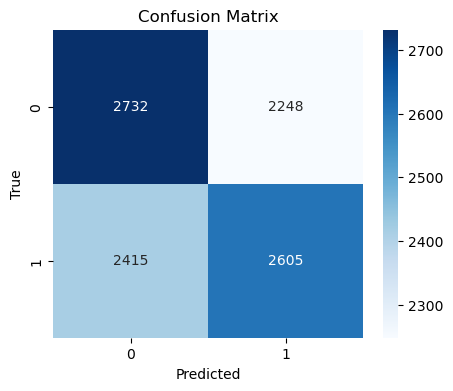


--- Training KNN ---
Accuracy: 0.5719 | Precision: 0.5735 | Recall: 0.5743 | F1: 0.5739

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.57      0.57      4980
           1       0.57      0.57      0.57      5020

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000



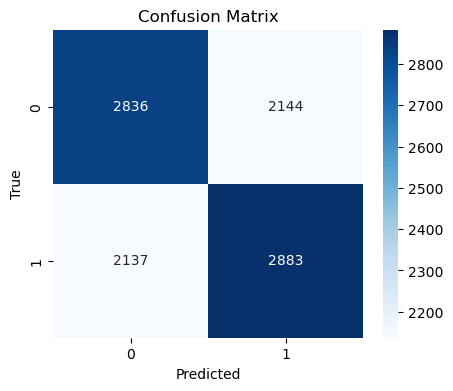


--- Training Naive Bayes ---
Accuracy: 0.5362 | Precision: 0.5386 | Recall: 0.5307 | F1: 0.5346

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.54      0.54      4980
           1       0.54      0.53      0.53      5020

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.54     10000
weighted avg       0.54      0.54      0.54     10000



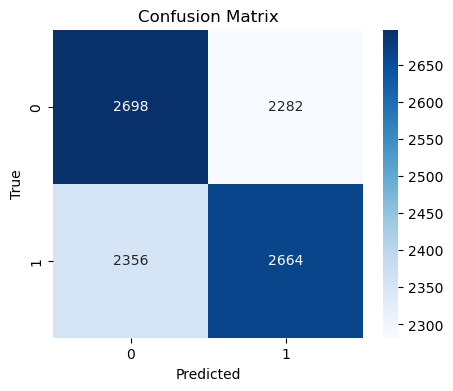


--- Training Decision Tree ---
Accuracy: 0.6769 | Precision: 0.6890 | Recall: 0.6496 | F1: 0.6687

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.70      0.68      4980
           1       0.69      0.65      0.67      5020

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



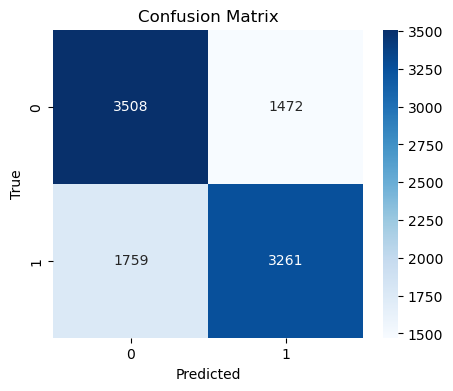


--- Training Random Forest ---
Accuracy: 0.6649 | Precision: 0.6673 | Recall: 0.6631 | F1: 0.6652

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.66      4980
           1       0.67      0.66      0.67      5020

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000



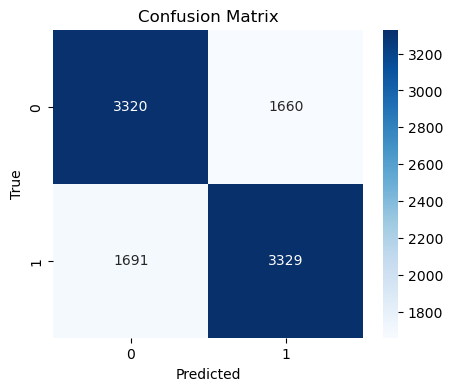


--- Training SVM ---
Accuracy: 0.5458 | Precision: 0.5458 | Recall: 0.5679 | F1: 0.5566

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.52      0.53      4980
           1       0.55      0.57      0.56      5020

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000



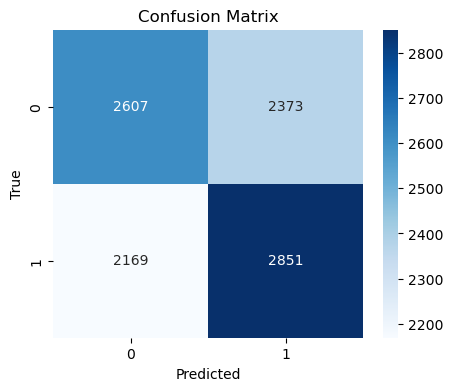


--- Training Gradient Boosting ---
Accuracy: 0.5494 | Precision: 0.5520 | Recall: 0.5430 | F1: 0.5475

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.56      0.55      4980
           1       0.55      0.54      0.55      5020

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000



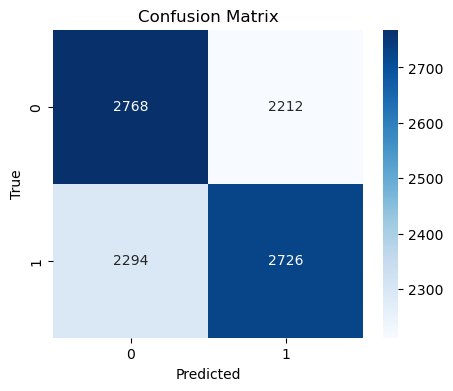


--- Training AdaBoost ---


/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Accuracy: 0.5435 | Precision: 0.5445 | Recall: 0.5544 | F1: 0.5494

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.53      0.54      4980
           1       0.54      0.55      0.55      5020

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.54     10000
weighted avg       0.54      0.54      0.54     10000



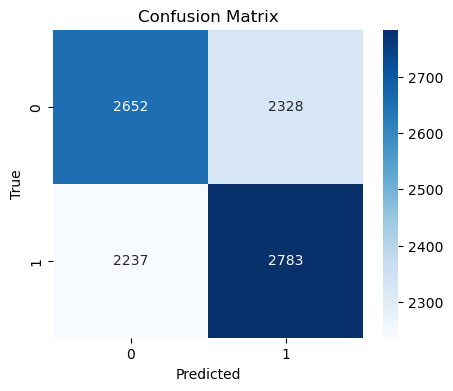


--- Training Extra Trees ---
Accuracy: 0.6491 | Precision: 0.6620 | Recall: 0.6151 | F1: 0.6377

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.68      0.66      4980
           1       0.66      0.62      0.64      5020

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000



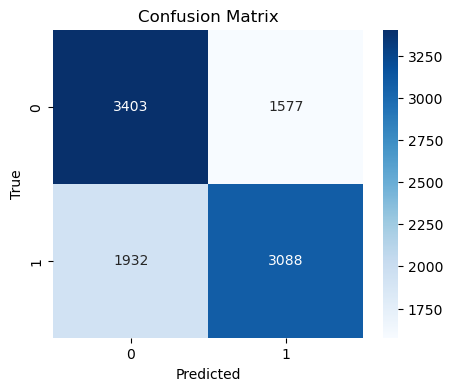


--- Training XGBoost ---
Accuracy: 0.6679 | Precision: 0.6712 | Recall: 0.6633 | F1: 0.6673

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.67      4980
           1       0.67      0.66      0.67      5020

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000



/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [11:57:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


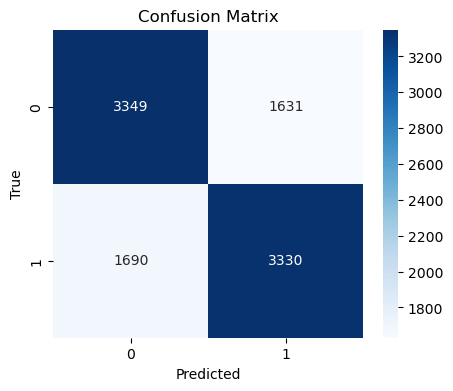

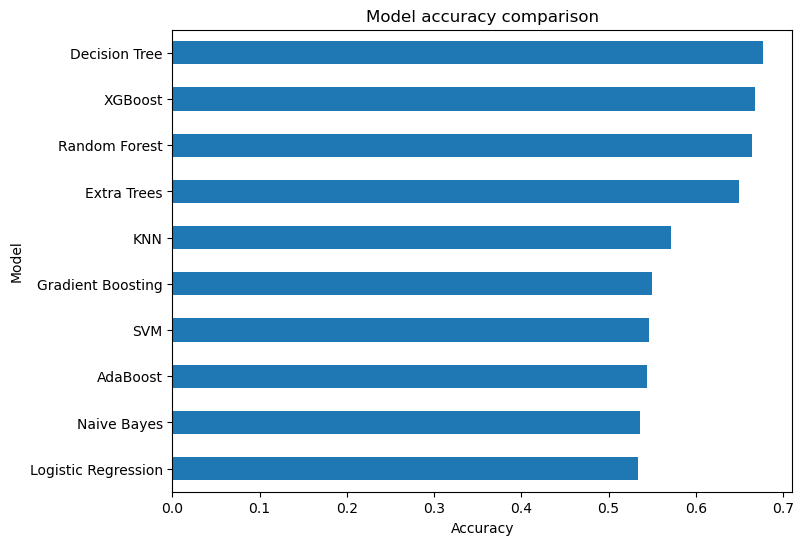


Hoàn thành huấn luyện & đánh giá!


In [15]:
# Khởi tạo danh sách các mô hình (classification)
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42, probability=True),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42, algorithm='SAMME'),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
}

# Train & evaluate using helper function (handles confusion matrix, precision, recall)
if 'X_train_scaled' in locals():
    print("Bắt đầu huấn luyện và đánh giá các mô hình...")
    # Train and evaluate; the helper will fit the models and show confusion matrices
    results_df = train_and_evaluate(models, X_train_scaled, X_test_scaled, y_train, y_test)
    print("\nHoàn thành huấn luyện & đánh giá!")
else:
    print("Không có dữ liệu huấn luyện (X_train_scaled) để chạy mô hình.")

Order-level shape: (11714, 12)
Profitable ratio: 0.5
Train / Test sizes: (9371, 7) (2343, 7)

Baseline training on order-level:

--- Training Logistic ---
Accuracy: 0.8626 | Precision: 0.8582 | Recall: 0.8685 | F1: 0.8633

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86      1172
           1       0.86      0.87      0.86      1171

    accuracy                           0.86      2343
   macro avg       0.86      0.86      0.86      2343
weighted avg       0.86      0.86      0.86      2343



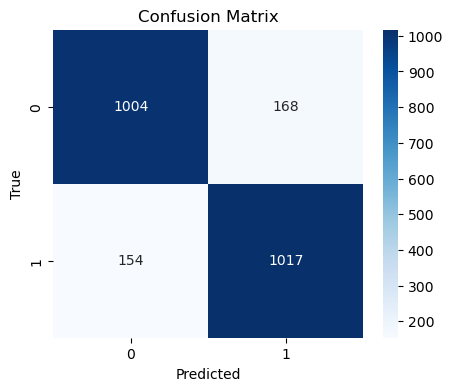


--- Training KNN ---
Accuracy: 0.8481 | Precision: 0.8382 | Recall: 0.8625 | F1: 0.8502

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.85      1172
           1       0.84      0.86      0.85      1171

    accuracy                           0.85      2343
   macro avg       0.85      0.85      0.85      2343
weighted avg       0.85      0.85      0.85      2343



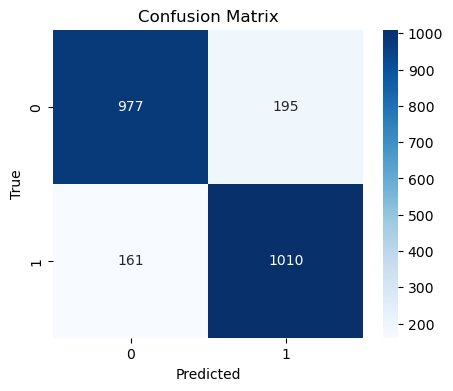


--- Training RandomForest ---
Accuracy: 0.8839 | Precision: 0.8700 | Recall: 0.9026 | F1: 0.8860

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      1172
           1       0.87      0.90      0.89      1171

    accuracy                           0.88      2343
   macro avg       0.88      0.88      0.88      2343
weighted avg       0.88      0.88      0.88      2343



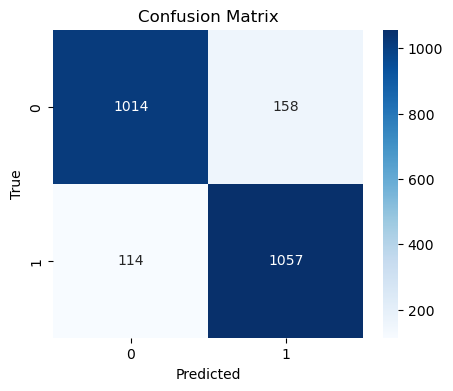


--- Training XGBoost ---
Accuracy: 0.8822 | Precision: 0.8683 | Recall: 0.9009 | F1: 0.8843

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      1172
           1       0.87      0.90      0.88      1171

    accuracy                           0.88      2343
   macro avg       0.88      0.88      0.88      2343
weighted avg       0.88      0.88      0.88      2343



/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:13:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


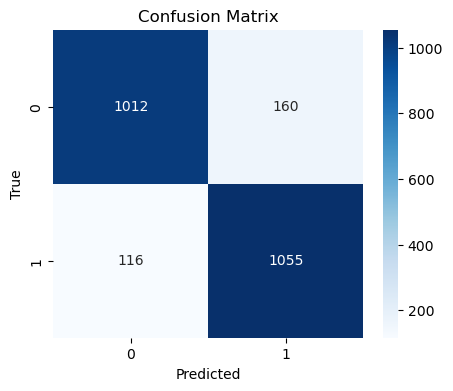

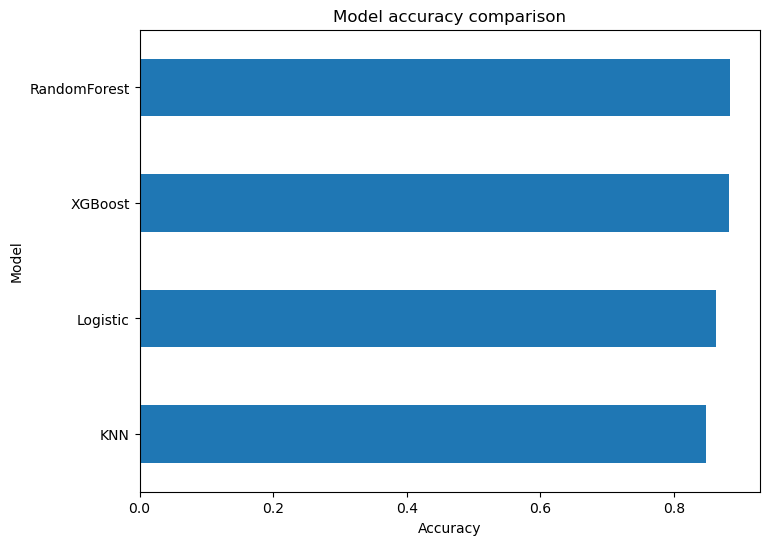

              accuracy  precision    recall        f1
Model                                                
Logistic      0.862569   0.858228  0.868488  0.863328
KNN           0.848058   0.838174  0.862511  0.850168
RandomForest  0.883910   0.869959  0.902647  0.886002
XGBoost       0.882202   0.868313  0.900939  0.884325

Randomized search: RandomForest and XGBoost
RF best params: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 10}


/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:13:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:13:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:13:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:13:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

XGB best params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01}

Evaluation for tuned models:

-- RandomForest_tuned
Accuracy: 0.8856 | Precision: 0.8674 | Recall: 0.9103 | F1: 0.8883

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88      1172
           1       0.87      0.91      0.89      1171

    accuracy                           0.89      2343
   macro avg       0.89      0.89      0.89      2343
weighted avg       0.89      0.89      0.89      2343



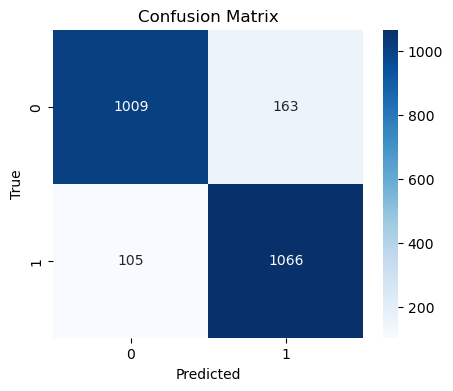


-- XGBoost_tuned
Accuracy: 0.8869 | Precision: 0.8647 | Recall: 0.9172 | F1: 0.8902

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88      1172
           1       0.86      0.92      0.89      1171

    accuracy                           0.89      2343
   macro avg       0.89      0.89      0.89      2343
weighted avg       0.89      0.89      0.89      2343



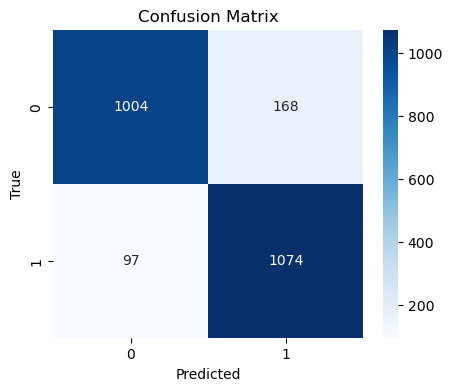


Saved order-level dataset to cleandata/order_level_data.csv


Exception ignored in: <function ResourceTracker.__del__ at 0x107549bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107315bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1026c9bc0>
Traceback (most recent call last

In [ ]:
# Build order-level dataset
from src.features import aggregate_order_level
from sklearn.model_selection import RandomizedSearchCV

order_agg = aggregate_order_level(df)
# merge order-level info (USERID, TOTALBASKET, Month, Age, USERGENDER, REGION)
order_info = df.groupby('ORDERID').agg({'USERID':'first','TOTALBASKET':'first','Month':'first','Age':'first','USERGENDER':'first','REGION':'first'}).reset_index()
order_df = order_agg.merge(order_info, on='ORDERID', how='left')

# Define target: profitable if total_revenue > median
threshold = order_df['total_revenue'].median()
order_df['profitable'] = (order_df['total_revenue'] > threshold).astype(int)
print('Order-level shape:', order_df.shape)
print('Profitable ratio:', order_df['profitable'].mean())

# Prepare features
feature_cols = ['total_items','unique_items','avg_unit_price','Month','Age']
# encode categorical fields
from sklearn.preprocessing import LabelEncoder
for col in ['USERGENDER','REGION']:
    if col in order_df.columns:
        order_df[col] = order_df[col].fillna('NA')
        le = LabelEncoder()
        order_df[col+'_enc'] = le.fit_transform(order_df[col])
        feature_cols.append(col+'_enc')

X_ord = order_df[feature_cols].copy()
y_ord = order_df['profitable']

# Train/test split (order-level) - stratify by target to keep balance
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_ord, y_ord, test_size=0.2, random_state=42, stratify=y_ord)
print('Train / Test sizes:', X_train_o.shape, X_test_o.shape)

# Scale numeric features when needed (we'll use pipelines later)
from sklearn.preprocessing import StandardScaler
scaler_o = StandardScaler()
X_train_o_s = scaler_o.fit_transform(X_train_o)
X_test_o_s = scaler_o.transform(X_test_o)

# Baseline: train a few models on order-level
base_models = {
    'Logistic': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
}

print('\nBaseline training on order-level:')
base_results = train_and_evaluate(base_models, X_train_o_s, X_test_o_s, y_train_o, y_test_o, plot_summary=True)
print(base_results)

# Hyperparameter tuning (RandomizedSearchCV) for RandomForest and XGBoost
print('\nRandomized search: RandomForest and XGBoost')
rf_param = {'n_estimators':[100,200,300], 'max_depth':[None,5,10,20], 'min_samples_split':[2,5,10]}
rs_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param, n_iter=8, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
rs_rf.fit(X_train_o, y_train_o)
print('RF best params:', rs_rf.best_params_)
best_rf = rs_rf.best_estimator_

xgb_param = {'n_estimators':[100,200], 'max_depth':[3,5,7], 'learning_rate':[0.01,0.1,0.2]}
rs_xgb = RandomizedSearchCV(xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False), xgb_param, n_iter=6, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
rs_xgb.fit(X_train_o, y_train_o)
print('XGB best params:', rs_xgb.best_params_)
best_xgb = rs_xgb.best_estimator_

# Evaluate tuned models
print('\nEvaluation for tuned models:')
for name, model in [('RandomForest_tuned', best_rf), ('XGBoost_tuned', best_xgb)]:
    y_pred = model.predict(X_test_o)
    print('\n--', name)
    evaluate_classification(y_test_o, y_pred)

# Save order-level dataset for further analysis
order_df.to_csv('data/order_level_data.csv', index=False)
print('\nSaved order-level dataset to data/order_level_data.csv')

## 3. So sánh và Trực quan hóa kết quả

### Time Series (Dự báo doanh thu theo thời gian)

- Tính tổng `TOTALPRICE` theo tháng.
- Hiển thị chuỗi thời gian (Monthly Revenue).
- Ví dụ forecasting đơn giản bằng RandomForestRegressor trên đặc trưng lag/rolling.

Lưu ý: Đây là ví dụ minh hoạ; có thể dùng ARIMA/Prophet để cải thiện.


In [ ]:
# --- Time Series: Doanh thu theo thời gian (monthly) ---
print('\nTime Series: Aggregate revenue by month and visualize')
# Ensure DATE_ is parsed correctly (dayfirst format in dataset)
df['DATE_dt'] = pd.to_datetime(df['DATE_'], dayfirst=True, errors='coerce')

monthly = df.set_index('DATE_dt').resample('M').agg({'TOTALPRICE':'sum'}).rename(columns={'TOTALPRICE':'Revenue'})
monthly = monthly.fillna(0)

plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly['Revenue'], marker='o')
plt.title('Monthly Revenue')
plt.ylabel('Revenue')
plt.xlabel('Month')
plt.grid(True)
plt.show()

# Simple forecasting: use lag features and RandomForestRegressor to predict next-month revenue
from sklearn.ensemble import RandomForestRegressor
ms = monthly.copy()
ms['lag_1'] = ms['Revenue'].shift(1)
ms['lag_2'] = ms['Revenue'].shift(2)
ms['roll_mean_3'] = ms['Revenue'].rolling(3).mean()
ms = ms.dropna()

X_ts = ms[['lag_1','lag_2','roll_mean_3']]
y_ts = ms['Revenue']

# Train/test split: last 6 months as test
split_idx = int(len(ms) - 6)
X_train_ts, X_test_ts = X_ts.iloc[:split_idx], X_ts.iloc[split_idx:]
y_train_ts, y_test_ts = y_ts.iloc[:split_idx], y_ts.iloc[split_idx:]

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_ts, y_train_ts)
y_pred_ts = rf_reg.predict(X_test_ts)

plt.figure(figsize=(10,5))
plt.plot(y_test_ts.index, y_test_ts.values, label='Actual')
plt.plot(y_test_ts.index, y_pred_ts, label='Predicted')
plt.title('Time Series Forecast: Actual vs Predicted (last 6 months)')
plt.legend()
plt.show()

In [ ]:
if 'results_df' in locals() and not results_df.empty:
    print(results_df)

    # Vẽ biểu đồ so sánh Accuracy
    res = results_df.reset_index().rename(columns={'accuracy':'Accuracy'})
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Accuracy', y='Model', data=res, palette='viridis')
    plt.title("So sánh độ chính xác (Accuracy) giữa các mô hình")
    plt.xlim(0, 1.0)
    plt.show()

## 4. Feature Importance (Từ Random Forest)
Phân tích xem yếu tố nào ảnh hưởng lớn nhất đến kết quả phân loại.

### Market Basket Analysis / Product Recommendation

- Chuyển `ORDERID` -> tập các `ITEMCODE` (transaction list).
- Tạo bảng one-hot và thực hiện Apriori (nếu `mlxtend` cài đặt) để tìm frequent itemsets và association rules.
- Hiển thị các sản phẩm thường xuất hiện cùng nhau và vẽ biểu đồ top-k items.

Lưu ý: `mlxtend` không bắt buộc nhưng cần để chạy apriori/rules.


In [ ]:
# --- Market Basket Analysis / Product Recommendation ---
print('\nMarket Basket Analysis: frequent itemsets and association rules')

# Prepare transaction data: one transaction = ORDERID, items are ITEMCODE (or ITEMID)
trans = df.groupby('ORDERID')['ITEMCODE'].apply(lambda x: list(x.astype(str))).tolist()

# Create one-hot dataframe
from collections import defaultdict
itemset = defaultdict(int)
unique_items = sorted({item for tx in trans for item in tx})

# Build one-hot encoded transactions frame
one_hot = []
for tx in trans:
    row = {item: (1 if item in tx else 0) for item in unique_items}
    one_hot.append(row)

trans_df = pd.DataFrame(one_hot)

# Use mlxtend if available for apriori/rules
try:
    from mlxtend.frequent_patterns import apriori, association_rules
    freq_items = apriori(trans_df, min_support=0.01, use_colnames=True)
    rules = association_rules(freq_items, metric='lift', min_threshold=1.2)
    print('Top 5 frequent itemsets:')
    print(freq_items.sort_values('support', ascending=False).head())
    print('\nTop 5 association rules:')
    print(rules.sort_values('lift', ascending=False).head())
except Exception as e:
    print('mlxtend not available or error generating rules:', e)
    print('You can `pip install mlxtend` to enable Apriori/association rules analysis.')

# Recommend top co-occurring items for a given item (simple co-occurrence)
coocc = trans_df.T.dot(trans_df)
for item in coocc.columns[:5]:
    top = coocc[item].sort_values(ascending=False).head(6).index.tolist()
    print(f"Item {item} top co-occurring: {top}")

# Plot top 20 frequent items
freq = trans_df.sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10,5))
sns.barplot(x=freq.values, y=freq.index)
plt.title('Top 20 Most Frequent Items (by ORDER count)')
plt.xlabel('Frequency')
plt.show()

In [7]:
if 'models' in locals() and "Random Forest" in models:
    rf_model = models["Random Forest"]
    # Chỉ vẽ nếu đã huấn luyện thành công
    if hasattr(rf_model, "feature_importances_"):
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 5))
        plt.title("Feature Importance (Random Forest)")
        plt.bar(range(X.shape[1]), importances[indices], align="center")
        plt.xticks(range(X.shape[1]), [feature_cols[i] for i in indices])
        plt.tight_layout()
        plt.show()

In [10]:
# Diagnostics: kiểm tra dữ liệu để tìm vấn đề
print('Shape:', df.shape)
print('Columns:', df.columns.tolist())
print('\n--- Head ---')
print(df.head(8))

print('\n--- Dtypes ---')
print(df.dtypes)

print('\n--- Missing values (count, percent) ---')
missing = df.isna().sum()
missing_pct = (missing / len(df) * 100).round(2)
print(pd.concat([missing, missing_pct], axis=1, keys=['count','percent']).sort_values('percent', ascending=False).head(30))

# Check TOTALBASKET if present
if 'TOTALBASKET' in df.columns:
    print('\nTOTALBASKET dtype:', df['TOTALBASKET'].dtype)
    print('First 10 TOTALBASKET values:', df['TOTALBASKET'].head(10).tolist())
    print('Strings in TOTALBASKET:', df['TOTALBASKET'].apply(lambda x: isinstance(x, str)).sum())
    # Check numeric range if convertible
    try:
        tb = pd.to_numeric(df['TOTALBASKET'], errors='coerce')
        print('TOTALBASKET (min, median, max):', tb.min(), tb.median(), tb.max())
    except Exception as e:
        print('Cannot convert TOTALBASKET to numeric:', e)

# Check Age
if 'Age' in df.columns:
    print('\nAge stats:')
    print(df['Age'].describe())

# Check duplicates for order/customer ids
for col in ['ORDERID', 'USERID']:
    if col in df.columns:
        print(f"\nDuplicate {col}:", df[col].duplicated().sum())

# Show value counts for a few categorical cols
for col in ['USERGENDER', 'REGION', 'Month']:
    if col in df.columns:
        print(f"\nValue counts for {col} (top 10):")
        print(df[col].value_counts(dropna=False).head(10))

print('\nDiagnostics complete')

Shape: (50000, 26)
Columns: ['ORDERID', 'ORDERDETAILID', 'AMOUNT', 'UNITPRICE', 'TOTALPRICE', 'ITEMID', 'ITEMCODE', 'BRANCH_ID', 'DATE_', 'USERID', 'NAMESURNAME_x', 'TOTALBASKET', 'USERNAME_', 'NAMESURNAME_y', 'STATUS_', 'USERGENDER', 'USERBIRTHDATE', 'REGION', 'CITY', 'TOWN', 'DISTRICT', 'ADDRESSTEXT', 'Year', 'Month', 'Age', 'HighValueCustomer']

--- Head ---
   ORDERID  ORDERDETAILID  AMOUNT  UNITPRICE  TOTALPRICE  ITEMID  ITEMCODE  \
0  6420952       32112344       4      95.40      422.36   10296     11170   
1  7219622       36109907       3      15.00       49.05    5123     25003   
2  4159842       20801845       3       7.85       14.22    5492      6167   
3  7594409       37983589       4       8.70       28.16    1264      2787   
4  7283856       36430669       3      57.25      164.34   16277     29876   
5  1488239        7439961       2      86.80      172.16    3633      9274   
6   312557        1566322       5      51.30      274.65    4278     12377   
7  9586219  

### Customer Churn Prediction (RFM)

- Tạo bộ đặc trưng RFM (recency, frequency, monetary) theo `USERID`.
- Gán nhãn churn (ví dụ: recency > 180 ngày → churned).
- Train các mô hình cơ bản (Logistic, Random Forest) và đánh giá bằng metrics đã định.


In [ ]:
# --- Customer Churn Prediction (RFM + simple churn label) ---
print('\nCustomer Churn Prediction: build RFM features and predict churn')
# Build RFM table per customer
cust = df.copy()
cust['DATE_dt'] = pd.to_datetime(cust['DATE_'], dayfirst=True, errors='coerce')
ref_date = cust['DATE_dt'].max() + pd.Timedelta(days=1)

rfm = cust.groupby('USERID').agg(
    recency_days = ('DATE_dt', lambda x: (ref_date - x.max()).days),
    frequency = ('ORDERID', 'nunique'),
    monetary = ('TOTALPRICE', 'sum')
).reset_index()

# Define churn label: customers with recency > 180 days considered churned
rfm['churn'] = (rfm['recency_days'] > 180).astype(int)
print('Churn distribution (0 active, 1 churn):')
print(rfm['churn'].value_counts())

# Prepare features & split
feature_cols_rfm = ['recency_days','frequency','monetary']
X_r = rfm[feature_cols_rfm]
y_r = rfm['churn']

from sklearn.model_selection import train_test_split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_r, y_r, test_size=0.2, random_state=42, stratify=y_r)

# Scale
from sklearn.preprocessing import StandardScaler
scaler_r = StandardScaler()
Xr_train_s = scaler_r.fit_transform(Xr_train)
Xr_test_s = scaler_r.transform(Xr_test)

# Use RandomForest + LogisticRegression as baseline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

churn_models = {
    'Logistic': LogisticRegression(max_iter=1000),
    'RF': RandomForestClassifier(random_state=42)
}

print('\nTraining churn models...')
churn_results = train_and_evaluate(churn_models, Xr_train_s, Xr_test_s, yr_train, yr_test, plot_summary=True)
print('\nChurn modeling complete')